# BENSON PROJECT

## Team members:  
Christine Liu  
Wendy Sanchez-Vaynshteyn  
Malik Salam  
Mauro Mario Gentile

## Data issues found

* Problems with 4 hour interval refreshing
* Sometimes turnstile doesn’t give a reading
* Sometimes turnstile spazzes out 
* Entries and Exits are cumalative, turnstile refreshes randomly
* Exits counting sometimes decreases and/or resets
* Duplictaed rows
* Outliers
* Consecutive readigs are not always 4 hours apart
* Readings does not happen alaways at the same hour across SCP
* LINENAME has inconsistent ordering (i.e. NQRW123 and 123NQRW are both present)
* Columns names have spaces



## Assumptions

* There is seasonality in data 
* Show is in mid July 
* Beacuse the mentioned seasonalities, we focus on 1 month data from mid july backward


## Structure/data definition

The way we understood it:
* C/A represent a group of Units
* Units represent a group of SCP
* Stations may have 1 or more C/A
* A C/A DOES NOT represent a specific Subway entrance or exit at the street level


## Objective

* Phase 1: loading, cleaning the data and preparing the DB
* Phase 2: EDA
* Phase 3: looking for top stations by total flow, by weekday and by hours range
* Phase 4: looking for distribution of flow by hour and week day for a input station

______________________________________________________________________________________

# PHASE 1: LOADING, CLEANING DATA PREPARING DB

In [125]:
#Import libraries and set variables
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

#Environment variable set up
%matplotlib inline
sns.set(font_scale=1.5)
#sns.set_style({"figure.facecolor": "None","axes.labelcolor":'1', "xtick.color":"1","ytick.color":"1", "text.color":"1"})


In [126]:
# Read all raw data files previously stored locally in the short_term_data folder.
# At the time of running of the script, there was 4 weeks of data, starting from 17/06/17

path =r'short_term_data/' # 
allFiles = glob.glob(path + "*.txt")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_)
    list_.append(df)
df = pd.concat(list_)

In [127]:
#Delete spaces at the beginning and end of column names
df.columns=[c.strip() for c in  df.columns]

In [128]:
#Delete columns we do not think we need 
df=df.drop(["DESC","DIVISION"],axis=1)

In [129]:
#Sort LINENAMES characters in alphabetic orders: NQRW123 and 123NQRW will now look as the same group line
df["LINENAME"]=df["LINENAME"].apply(lambda x: ''.join(sorted(x)))

In [130]:
#Create a time+hour column as DateTime datatype
df['T_H']=pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%m/%d/%Y %H:%M:%S')

In [131]:
# check for columns data type
df.dtypes

C/A                 object
UNIT                object
SCP                 object
STATION             object
LINENAME            object
DATE                object
TIME                object
ENTRIES              int64
EXITS                int64
T_H         datetime64[ns]
dtype: object

In [132]:
#CHECK FOR DUPLICATES ON ENTRIES
entries_dup_lines=((df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "T_H"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))["ENTRIES"]>1).sum()

In [133]:
#Percentage of duplicated lines 
entries_dup_lines/len(df)
#negible. 

7.6179641752538049e-06

In [134]:
#DROP DUPLICATED LINES ON ENTRIES
df=df.drop_duplicates(['C/A', 'UNIT',  'STATION', 'LINENAME','SCP','T_H'])

In [135]:
#CHECK FOR DUPLICATED LINES ON EXISTS 
#CHECK JUST I CASE SINCE YOU MAY HAVE DUPLICTAED ON EXITS WHICH ARE NOT DUPLICATES ON ENTRIES
((df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "T_H"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False))["EXITS"]>1).sum()

0

In [136]:
#NO DUPLICATES FOUND ON EXITS, AFTER HAVING DROPPED DUPLICATES ON ENTRIES
#nothing to drop

In [137]:
#Tort Flow as ENTRIES+EXISTS
df["TOT"]=df.apply(lambda row: row["ENTRIES"]+row["EXITS"],axis=1)

In [138]:
#sort data by station first and for T_h afterwards in order to have readings for the same SCP in a chronolgical order
df=df.sort_values(["STATION", "LINENAME", "C/A","SCP",'T_H'])

In [139]:
# Place in each row the time of reading, the ENTRIES and teh exists of previous row, by group of C/A, UNIT, STATION, LINENAME AND SCP 
# Needed to caluclate the time, ENTRIES and EXIT differences between two consecutive readings

df['T_H_previous'] = df.groupby(['C/A', 'UNIT',  'STATION', 'LINENAME','SCP'])['T_H'].shift(1)

In [140]:
#create previous TOT
df['TOT_previous'] = df.groupby(['C/A', 'UNIT',  'STATION', 'LINENAME','SCP'])['TOT'].shift(1)

In [141]:
#create previous ENTRIES
df['ENTRIES_previous'] = df.groupby(['C/A', 'UNIT',  'STATION', 'LINENAME','SCP'])['ENTRIES'].shift(1)

#create previous EXITS
df['EXITS_previous'] = df.groupby(['C/A', 'UNIT',  'STATION', 'LINENAME','SCP'])['EXITS'].shift(1)
#creates NaN at the begining of the group!

In [142]:
# The above operations creates NaN at the begining of the group since
# there is not a"previous" row for the first row of each group

In [143]:
# drop these  lines with these NaN values
df=df.dropna(subset = ['TOT_previous']) 

In [144]:
#Calcultae the delta people, time, entries and exists as current reading-previous one


In [145]:
df["Delta_time"]=df.apply(lambda row: (row["T_H"]-row["T_H_previous"]).seconds,axis=1)

In [146]:
df["Delta_people"]=df.apply(lambda row: row["TOT"]-row["TOT_previous"],axis=1)

In [147]:
df["Delta_ENTRIES"]=df.apply(lambda row: row["ENTRIES"]-row["ENTRIES_previous"],axis=1)

In [148]:
df["Delta_EXITS"]=df.apply(lambda row: row["EXITS"]-row["EXITS_previous"],axis=1)

In [149]:
# Phase 1 is concluded. Let's save the results in a csv file in order to start from here 
# and not from scrath with time consuming operations
# in case we need to restrt the script

df.to_csv("End_phase1.csv",index=False)

# PHASE 2: EDA

In [150]:
# Read the file with results from Phase 1.
# Transform time columns to datetime 
df=pd.read_csv("End_phase1.csv",index_col=False)
df['T_H']=pd.to_datetime(df['T_H'], format='%Y/%m/%d %H:%M:%S')
df['T_H_previous']=pd.to_datetime(df['T_H_previous'], format='%Y/%m/%d %H:%M:%S')


In [151]:
# check for negative deltas for EXITS, ie for decreasing readings
len(df[df["Delta_EXITS"]<0])/len(df)

0.0065538048087632715

In [152]:
#less than 1%. We can drop these cases

In [153]:
df=df[df["Delta_EXITS"]>0]

In [154]:
# repeat for EXITS
len(df[df["Delta_ENTRIES"]<0])/len(df)

0.005425047034077577

In [155]:
#Less than 1%. We can drop them
df=df[df["Delta_ENTRIES"]>0]

In [156]:
#Check on delta people
len(df[df["Delta_people"]<0])

0

In [157]:
# Quick look to statistics about numerical variables
df.describe()

,ENTRIES,EXITS,TOT,TOT_previous,ENTRIES_previous,EXITS_previous,Delta_time,Delta_people,Delta_ENTRIES,Delta_EXITS
count,6.421180e+05,6.421180e+05,6.421180e+05,6.421180e+05,6.421180e+05,6.421180e+05,642118.000000,6.421180e+05,6.421180e+05,6.421180e+05
mean,2.517499e+07,1.805388e+07,4.322887e+07,4.320862e+07,2.516369e+07,1.804493e+07,14372.283643,2.024838e+04,1.129748e+04,8.950902e+03
std,1.533788e+08,1.226003e+08,2.645813e+08,2.644977e+08,1.533276e+08,1.225573e+08,1282.511616,6.752136e+06,4.016996e+06,3.283912e+06
min,1.000000e+00,2.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000e+00,1.000000e+00,1.000000e+00
25%,9.095765e+05,5.145598e+05,1.806725e+06,1.806238e+06,9.094370e+05,5.144360e+05,14400.000000,8.900000e+01,3.500000e+01,2.600000e+01
50%,3.139230e+06,1.859066e+06,5.747872e+06,5.747387e+06,3.139080e+06,1.858904e+06,14400.000000,2.490000e+02,1.210000e+02,7.900000e+01
75%,7.007132e+06,5.104377e+06,1.265404e+07,1.265280e+07,7.006848e+06,5.104126e+06,14400.000000,5.220000e+02,2.880000e+02,1.990000e+02
max,2.115149e+09,2.046862e+09,3.959348e+09,3.959346e+09,2.115148e+09,2.036414e+09,86282.000000,3.285201e+09,1.621023e+09,2.038812e+09


In [158]:
# The difference in values between the IQR and max values in DELTA ENTRIES, DELTA EXITS AND DELTA PEoPLE make
# suspect the presence of outliers

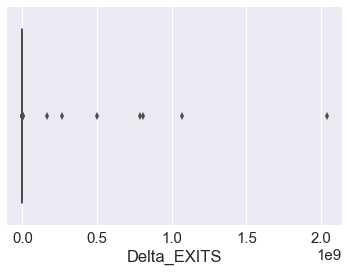

In [159]:
#Check with Boxplot
sns.boxplot(df.Delta_EXITS,whis=1.5);

(0, 2000)

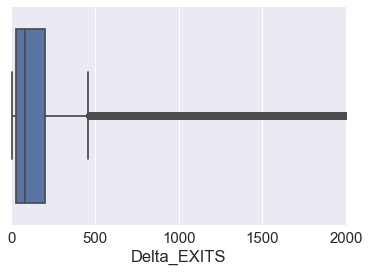

In [160]:
# there are very big outliers
# Closer llok to chose a cut off value
sns.boxplot(df.Delta_EXITS,whis=1.5);
plt.xlim([0,2000])

In [161]:
# Let's take 1000 as an arbitrary cuto fo value and caluculate the number of cut lines
previous_len=len(df)
df=df[df["Delta_EXITS"]<1000]
new_len=len(df)
new_len/previous_len

0.9855820892733111

In [162]:
# We heve cut less than 2% of values

In [163]:
# Repeat with ENTRIES

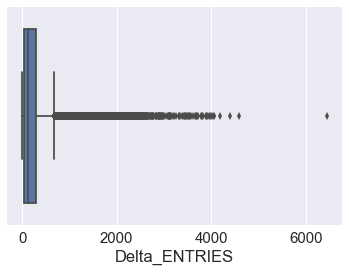

In [164]:
#Check with Boxplot
sns.boxplot(df.Delta_ENTRIES,whis=1.5);

(0, 2000)

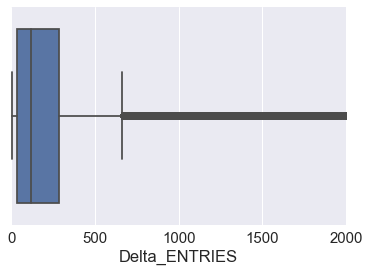

In [165]:
# zoom at 2000
sns.boxplot(df.Delta_ENTRIES,whis=1.5);
plt.xlim([0,2000])

In [166]:
# cut at the arbitrary number of 1400 and caluclate the percentage of row deleted
previous_len_len=len(df)
df=df[df["Delta_ENTRIES"]<1400]
new_len=len(df)
new_len/previous_len

0.9802808829529774

In [167]:
#Again we have cut less then 2% of readings

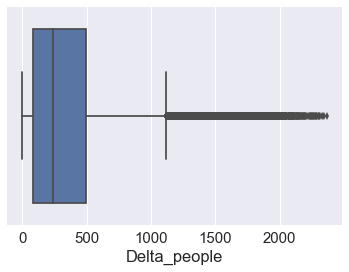

In [168]:
# final check on PEOPLE

sns.boxplot(df.Delta_people,whis=1.5);

In [169]:
# cut at 2000 anbd caluclate the percentage of deleted rows
previous_len=len(df)
df=df[df["Delta_people"]<2000]
new_len=len(df)
new_len/previous_len

0.9996473145064945

In [170]:
#virtually no row cut away this time

In [171]:
df.to_csv("End_of_phase2.csv",index=False) #write to file

# PHASE 3: LOOKING FOR TOP STATIONS BY TOTAL FLOW, WEEKDAY, HOUR

In [193]:
df=pd.read_csv("End_of_phase2.csv",index_col=False)
df['T_H']=pd.to_datetime(df['T_H'], format='%Y/%m/%d %H:%M:%S')
df['T_H_previous']=pd.to_datetime(df['T_H_previous'], format='%Y/%m/%d %H:%M:%S')

In [194]:
# Name of day
df["weekday"]=df['T_H'].dt.weekday_name


In [211]:
df

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,T_H,TOT,T_H_previous,TOT_previous,ENTRIES_previous,EXITS_previous,Delta_time,Delta_people,Delta_ENTRIES,Delta_EXITS,weekday
0,H007,R248,00-00-00,1 AV,L,06/10/2017,04:00:00,12410242,13697185,2017-06-10 04:00:00,26107427,2017-06-10 00:00:00,26106984.0,12410135.0,13696849.0,14400,443.0,107.0,336.0,Saturday
1,H007,R248,00-00-00,1 AV,L,06/10/2017,08:00:00,12410335,13697403,2017-06-10 08:00:00,26107738,2017-06-10 04:00:00,26107427.0,12410242.0,13697185.0,14400,311.0,93.0,218.0,Saturday
2,H007,R248,00-00-00,1 AV,L,06/10/2017,12:00:00,12410812,13698220,2017-06-10 12:00:00,26109032,2017-06-10 08:00:00,26107738.0,12410335.0,13697403.0,14400,1294.0,477.0,817.0,Saturday
3,H007,R248,00-00-00,1 AV,L,06/10/2017,16:00:00,12411555,13699166,2017-06-10 16:00:00,26110721,2017-06-10 12:00:00,26109032.0,12410812.0,13698220.0,14400,1689.0,743.0,946.0,Saturday
4,H007,R248,00-00-00,1 AV,L,06/11/2017,00:00:00,12412502,13701191,2017-06-11 00:00:00,26113693,2017-06-10 20:00:00,26112417.0,12412122.0,13700295.0,14400,1276.0,380.0,896.0,Sunday
5,H007,R248,00-00-00,1 AV,L,06/11/2017,04:00:00,12412593,13701589,2017-06-11 04:00:00,26114182,2017-06-11 00:00:00,26113693.0,12412502.0,13701191.0,14400,489.0,91.0,398.0,Sunday
6,H007,R248,00-00-00,1 AV,L,06/11/2017,08:00:00,12412644,13701797,2017-06-11 08:00:00,26114441,2017-06-11 04:00:00,26114182.0,12412593.0,13701589.0,14400,259.0,51.0,208.0,Sunday
7,H007,R248,00-00-00,1 AV,L,06/11/2017,12:00:00,12413036,13702347,2017-06-11 12:00:00,26115383,2017-06-11 08:00:00,26114441.0,12412644.0,13701797.0,14400,942.0,392.0,550.0,Sunday
8,H007,R248,00-00-00,1 AV,L,06/11/2017,16:00:00,12413581,13703190,2017-06-11 16:00:00,26116771,2017-06-11 12:00:00,26115383.0,12413036.0,13702347.0,14400,1388.0,545.0,843.0,Sunday
9,H007,R248,00-00-00,1 AV,L,06/11/2017,20:00:00,12414050,13704071,2017-06-11 20:00:00,26118121,2017-06-11 16:00:00,26116771.0,12413581.0,13703190.0,14400,1350.0,469.0,881.0,Sunday


In [204]:
#Group by station and linename (we will only will look after delta people, and other delta field:
# represnetning increments from one reading to the following one, when you sum them, you get the total 

#resampled=df.set_index('T_H').groupby(['C/A', 'UNIT', 'STATION', 'LINENAME',"weekday"]).sum()
Q=df.groupby(['STATION',"LINENAME"]).sum().reset_index()

In [206]:
#extarct the top 10 by total
Q=Q.sort_values(["Delta_people","LINENAME"],ascending=False).head(10)[["STATION","LINENAME","Delta_people"]]

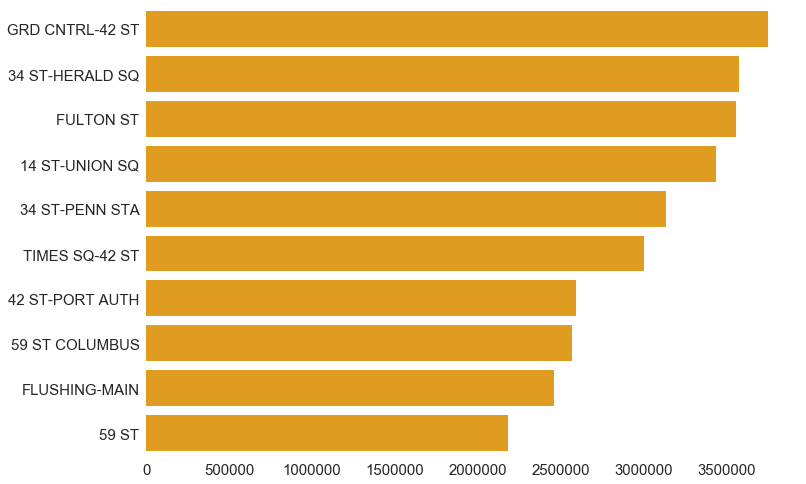

In [208]:
# Plot the top 10 by dalta people
a4_dims = (11.7, 8.27)
plt.subplots(figsize=a4_dims)
ax = sns.barplot(x="Delta_people", y="STATION", data=Q, color="Orange")
ax.patch.set_alpha(0.0)
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

In [216]:
# extract the hour of reading
df["hr"]=df.set_index(['T_H_previous']).index.hour

In [220]:
# extract only the columns needed from now on
resampled=df.reset_index()[["C/A","UNIT","SCP","STATION","LINENAME","Delta_time","Delta_people","weekday","hr"]]

In [221]:
# Define 4 hr time ranges and assign the correesponding to each reading
def hour_range(x):
    if x<4:
        return("0-4")
    elif x<8:
        return("4-8")
    elif x<12:
        return("8-12")
    elif x<16:
        return("12-16")
    elif x<20:
        return("16-20")
    else:
        return("20-24")
        
    
resampled["hr_range"]=resampled["hr"].apply(lambda x: hour_range(x))

In [222]:
# counts readings
resampled["hr_range"].value_counts()

12-16    108450
8-12     108398
4-8      107515
16-20    104055
20-24    103317
0-4       97499
Name: hr_range, dtype: int64

In [223]:
#Define weekday and hr_range as categorical range with a specified order (useful when it is time to plot)
resampled["weekday"] = pd.CategoricalIndex(resampled.weekday, categories= ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
resampled["hr_range"] = pd.CategoricalIndex(resampled.hr_range, categories= ["0-4","4-8","8-12","12-16","16-20","20-24"])

W 4 ST-WASH SQ NYU
68  Hunter
8st NYU
116st columbia
139 

In [226]:
# let's find the average flow by_week_day
# First we sum all the delta people to find the total flow in the period (sum of people incrementals)
# Then we sum all the delta tiem to find the total time in the period (sum of time incrementals)
# divinding the people incremental by the time incremental we get the average by second. Multiplying by 3600, he get
# the average by hour.
# NOTICE THAT BY TAKING THE AVERAGE IN THIS WAY, WE ARE NOT EXPOSED TO THE PROBLEM OF MISSING VALUES 
# INTRODUCED WHEN WE CUT OFF ROWS FOR ISTANCE BECAUSE OF OUTLIERS, NEGATIVE READINGS ETC. ETC.


In [229]:
by_week_day=resampled.groupby(["weekday"]).sum().reset_index()
by_week_day["average_flow_per_sec"]=by_week_day.apply(lambda row: row["Delta_people"]/row["Delta_time"]*3600, axis=1)

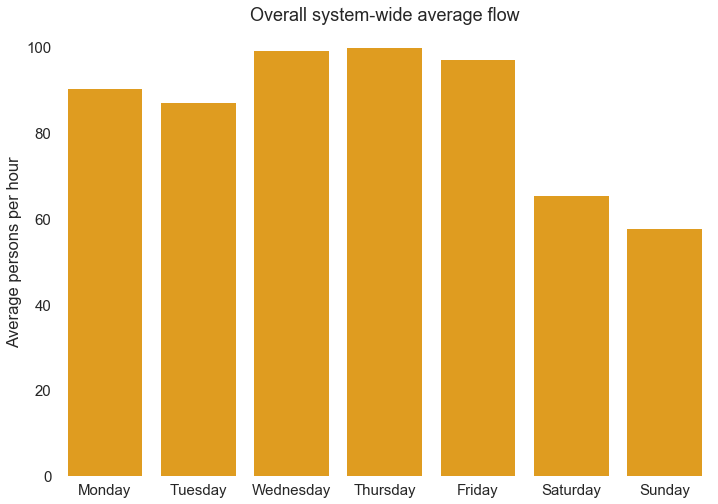

In [230]:

a4_dims = (11.7, 8.27)
plt.subplots(figsize=a4_dims)
ax = sns.barplot("weekday", y="average_flow_per_sec", data=by_week_day, color="Orange") 
ax.set_title("Overall system-wide average flow")
ax.set_ylabel('Average persons per hour')    
ax.patch.set_alpha(0.0)
ax.set_xlabel('')
plt.show()


In [231]:
by_hour_range=resampled.groupby(["hr_range"]).sum().reset_index()
by_hour_range["average"]=by_hour_range.apply(lambda row: row["Delta_people"]/row["Delta_time"]*3600, axis=1)


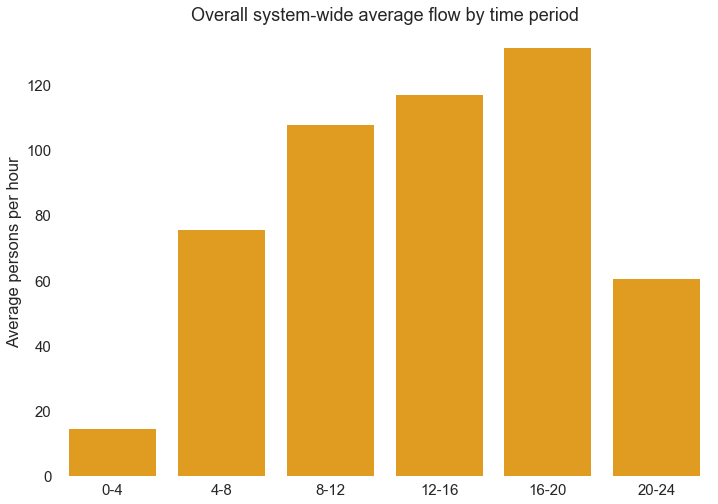

In [232]:
a4_dims = (11.7, 8.27)
plt.subplots(figsize=a4_dims)
ax = sns.barplot("hr_range", y="average",data=by_hour_range, color="Orange") 
ax.set_title("Overall system-wide average flow by time period")
ax.set_ylabel('Average persons per hour')  
ax.patch.set_alpha(0.0)
ax.set_xlabel('')
plt.show()


# PHASE 4:  FLOW DISTR. BY HOUR AND WEEKDAY FOR A SPECIFIC STATION 

In [234]:
# Usueful functions
# find_lines: find the Lines for an input station
# find_ca: find all combiantion of Lines and C/A for a specific station.
# create_hm_by_station: plot the heatmap of flow for a specific station
# create_hm_by_station_CA: plot the the heatmap of flow for a specific station, Line and C/A

def find_lines(StationName):
    return(resampled[(resampled["STATION"]==StationName)].LINENAME.unique())

def find_ca(StationName):
    A=resampled.groupby(["STATION","LINENAME","C/A"]).count().reset_index()[["STATION","LINENAME","C/A"]]
    return(A[A["STATION"]==StationName])


def create_hm_by_station(Station, Line):
    by_station=resampled[(resampled["STATION"]==Station) & (resampled["LINENAME"]==Line)]
    by_station=by_station.groupby(["STATION","LINENAME","hr_range","weekday"]).sum().reset_index()
    by_station["average"]=by_station.apply(lambda row: row["Delta_people"]/row["Delta_time"]*3600, axis=1)
    a4_dims = (11.7, 8.27)

    plt.subplots(figsize=a4_dims)
    title="Station: "+ Station+"    -    Line: "+Line
    A = by_station.pivot("weekday", "hr_range", "average")

    ax = plt.axes()
    ax = sns.heatmap(A, cmap="YlGnBu")
    plt.yticks(rotation=0)
    ax.set_title(title)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.show()
    
def create_hm_by_station_CA(Station, Line,CA):
    by_station=resampled[(resampled["STATION"]==Station) & (resampled["LINENAME"]==Line)& (resampled["C/A"]==CA)]
    by_station=by_station.groupby(["STATION","LINENAME","hr_range","weekday"]).sum().reset_index()
    by_station["average"]=by_station.apply(lambda row: row["Delta_people"]/row["Delta_time"]*3600, axis=1)
    a4_dims = (11.7, 8.27)

    plt.subplots(figsize=a4_dims)
    title="Station: "+ Station+"    -    Line: "+Line+"    -    C/A: "+CA
    A = by_station.pivot("weekday", "hr_range", "average")

    ax = plt.axes()
    ax = sns.heatmap(A, cmap="YlGnBu")
    plt.yticks(rotation=0)
    ax.set_title(title)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.show()


## PLOT 116 ST-COLUMBIA 

In [282]:
Station="116 ST-COLUMBIA"

In [283]:
# check lines and C/A in the station
find_ca(Station)

,STATION,LINENAME,C/A
20,116 ST-COLUMBIA,1,R173


In [284]:
#There is only 1 line and 1 C/A

Line="1"

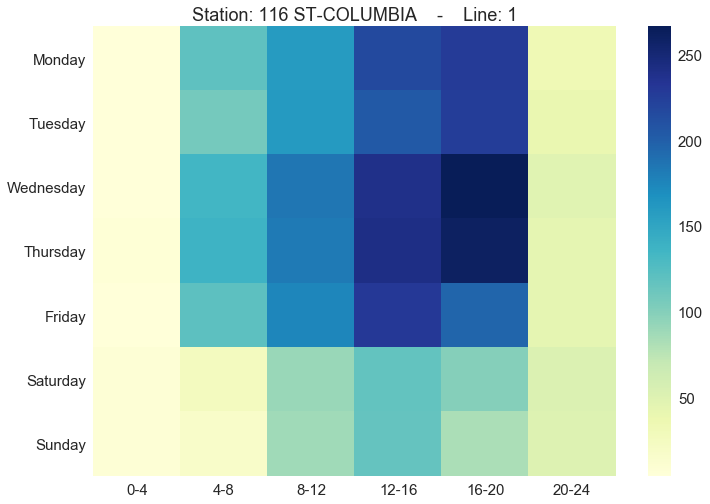

In [285]:
# plot by station
create_hm_by_station(Station, Line)

## PLOT 86th ST

In [286]:
Station="86 ST"

In [287]:
# check lines and C/A in the station
find_ca(Station)

,STATION,LINENAME,C/A
263,86 ST,1,R164
264,86 ST,1,R165
265,86 ST,1,R166
266,86 ST,456,R249
267,86 ST,456,R250
268,86 ST,BC,N043
269,86 ST,N,D016
270,86 ST,R,C025
271,86 ST,R,C026


In [288]:
#We are only interested in the station with LINES 4,5,and 6
Line="456"

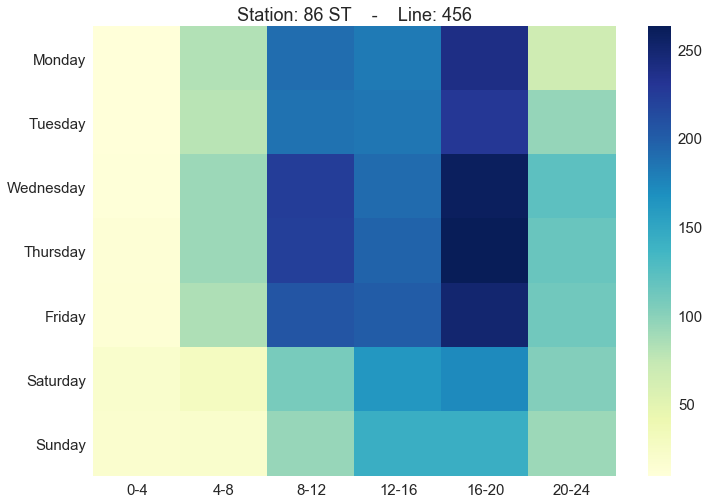

In [289]:
# plot by station (i.e THE AGGREGATE FLOW REGARDLESS THE C/A)
create_hm_by_station(Station, Line)

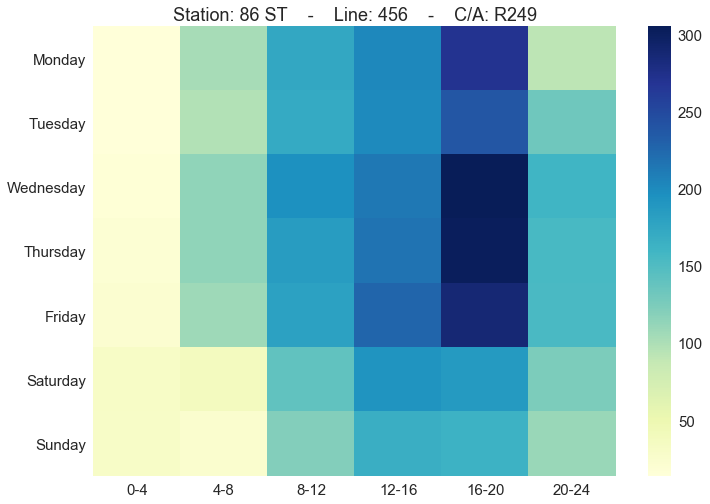

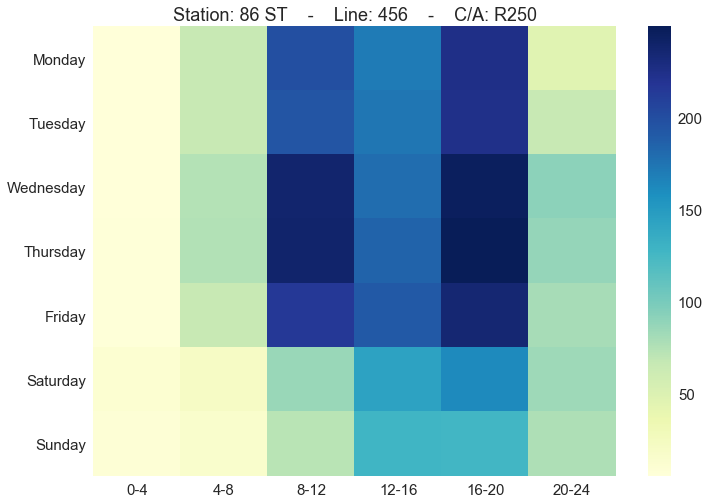

In [290]:
# Now plot the flow distribution by C/A
A=find_ca(Station)
for i in A.index:
    if A.loc[i,"LINENAME"] == Line:
        create_hm_by_station_CA(Station,A.loc[i,"LINENAME"],A.loc[i,"C/A"])

## PLOT 42 ST-PORT AUTH

In [292]:
Station="42 ST-PORT AUTH"

In [293]:
# check lines and C/A in the station
find_ca(Station)

,STATION,LINENAME,C/A
175,42 ST-PORT AUTH,1237ACEGNRSW,N060
176,42 ST-PORT AUTH,1237ACENQRSW,N062
177,42 ST-PORT AUTH,1237ACENQRSW,N062A
178,42 ST-PORT AUTH,1237ACENQRSW,N063
179,42 ST-PORT AUTH,1237ACENQRSW,N063A


In [294]:
#There are 2 group of line and 5 C/A. 
#we are interested in the group: 1237ACENQRSW

In [297]:
Line="1237ACENQRSW"

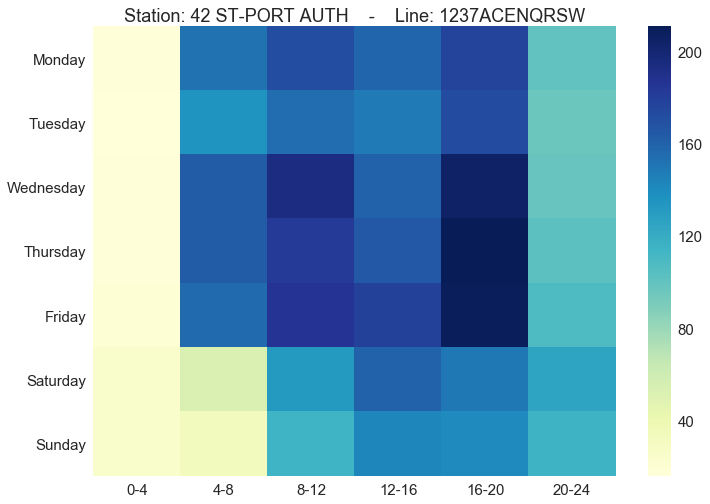

In [298]:
# plot by station (i.e THE AGGREGATE FLOW REGARDLESS THE C/A)
create_hm_by_station(Station, Line)

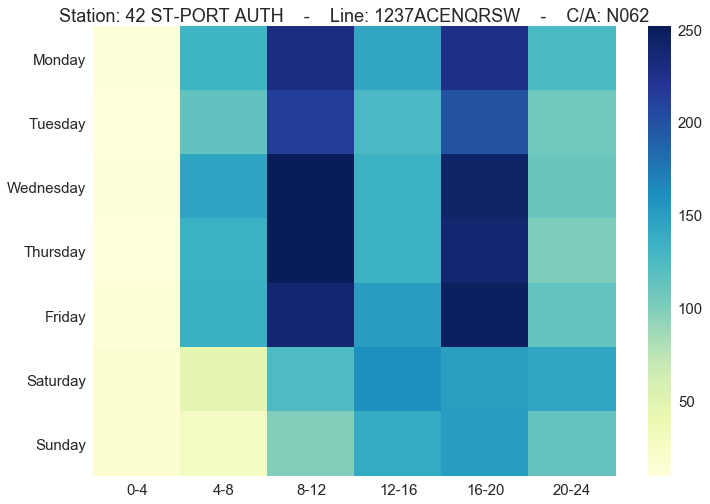

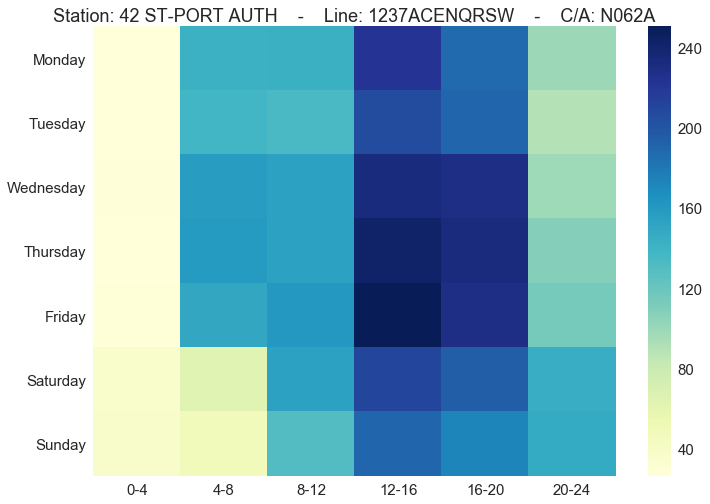

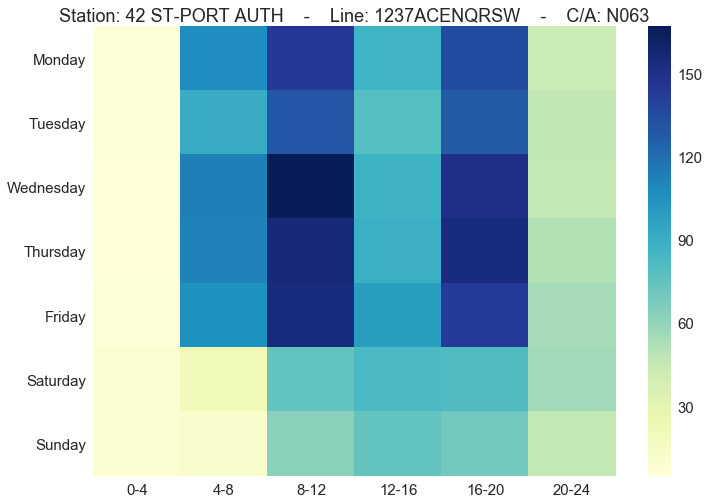

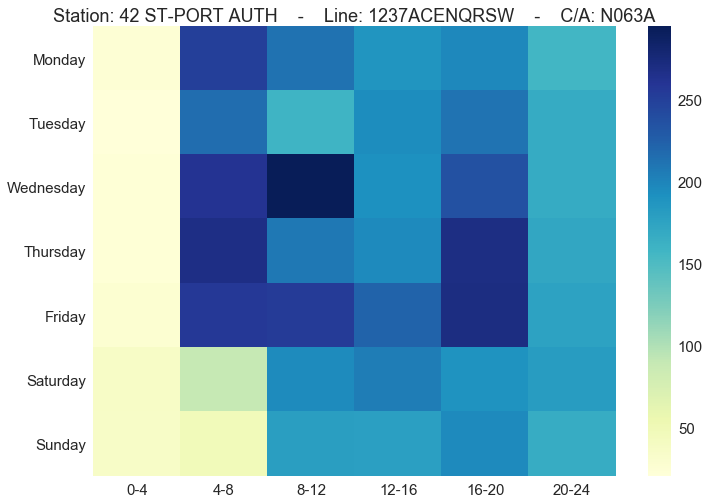

In [299]:
# Now plot the flow distribution by C/A
A=find_ca(Station)
for i in A.index:
    if A.loc[i,"LINENAME"] == Line:
        create_hm_by_station_CA(Station,A.loc[i,"LINENAME"],A.loc[i,"C/A"])